In [1]:
#default_exp opt

# Optimization and Metrics
> Here, we expose the functionality for optimizing the segmentation models, and evaluating them using the Dice loss and similarity, respectively.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#export
import torch
import torch.nn as nn

In [4]:
#export
class DiceLoss(nn.Module):
    """
    Module to compute the Dice segmentation loss. Based on the following discussion:
    https://discuss.pytorch.org/t/one-hot-encoding-with-autograd-dice-loss/9781
    """
    def __init__(self, weights=None, ignore_index=None, eps=0.0001):
        super(DiceLoss, self).__init__()
        self.weights = weights
        self.ignore_index = ignore_index
        self.eps = eps
        
    def forward(self, output, target):
        """
        Arguments:
            output: (N, C, H, W) tensor of probabilities for the predicted output
            target: (N, H, W) tensor corresponding to the pixel-wise labels
        Returns:
            loss: the Dice loss averaged over channels
        """ 
        encoded_target = output.detach() * 0
        if self.ignore_index is not None:
            mask = target == self.ignore_index
            target = target.clone()
            target[mask] = 0
            encoded_target.scatter_(1, target.unsqueeze(1), 1)
            mask = mask.unsqueeze(1).expand_as(encoded_target)
            encoded_target[mask] = 0
        else:
            encoded_target.scatter_(1, target.unsqueeze(1), 1)

        if self.weights is None:
            self.weights = 1

        intersection = output * encoded_target
        numerator = 2 * intersection.sum(0).sum(1).sum(1)
        denominator = output + encoded_target

        if self.ignore_index is not None:
            denominator[mask] = 0
        denominator = denominator.sum(0).sum(1).sum(1) + self.eps
        loss_per_channel = self.weights * (1 - (numerator / denominator))

        return loss_per_channel.sum() / output.size(1)

In [5]:
#export
def dice_similarity(prediction, target, weights=None, ignore_index=None, eps=1e-8):
    """
    Arguments:
        output: (N, H, W) tensor of predictions
        target: (N, H, W) tensor corresponding to the pixel-wise labels
    Returns:
        loss: the Dice loss averaged over channels
    """ 
    encoded_prediction = output.detach() * 0
    encoded_prediction.scatter_(1, prediction.unsqueeze(1), 1)
    
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = encoded_prediction * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1) + eps
    denominator = intersection + encoded_target
    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    acc_per_channel = weights * ((numerator / denominator))

    return acc_per_channel.sum() / output.size(1)

Now, we train our dynamic U-Net. First, let's initialize the dataset, and see an example datapoint.

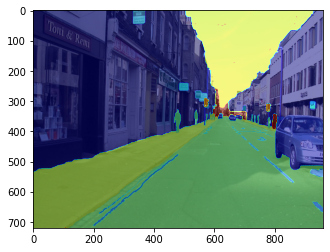

In [13]:
#example
import torch
from dynamic_unet.utils import CamvidDataset, load_camvid_dataset, display_segmentation_from_file
camvid_data_directory = "/home/jupyter/data/camvid"
all_data, val_indices, label_mapping = load_camvid_dataset(camvid_data_directory)
tr_data, val_data = [tpl for i, tpl in enumerate(all_data) if i not in val_indices], \
                    [tpl for i, tpl in enumerate(all_data) if i in val_indices]

i = 10
display_segmentation_from_file(tr_data[i][0], tr_data[i][1])

tr_ds, val_ds = CamvidDataset(tr_data, resize_shape=(360, 480)),\
                CamvidDataset(val_data, resize_shape=(360, 480), is_train=False)
tr_dl, val_dl = torch.utils.data.DataLoader(tr_ds, batch_size=4, shuffle=True), torch.utils.data.DataLoader(val_ds)

Finally, we initialize our model, optimizer, and criterion to optimize (here, we use the Dice loss to optimize directly for the Dice metric). We'll also initialize a scheduler for faster training.

In [8]:
#example
from dynamic_unet.encoder import resnet34
from dynamic_unet.unet import DynamicUNet

model = DynamicUNet(resnet34(), num_output_channels=32, input_size=(360, 480))
if torch.cuda.is_available():
    model = model.cuda()

decoder_parameters = [item for module in model.decoder for item in module.parameters()]
optimizer = torch.optim.AdamW(decoder_parameters)  # Only training the decoder for now

criterion = DiceLoss()

# Training specific parameters
num_epochs = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-2,
    total_steps=num_epochs * len(tr_dl),
)

Here's an example of what training for 10 epochs to fine-tune the decoder to be on par with the pre-trained weights being used in the ResNet encoder. We're using the default learning rate for Adam, $10^{-3}$. We print the per-pixel accuracy, as well as the Dice similarity (which is the F1 score).

In [9]:
#example
from tqdm.notebook import tqdm
model.train()
losses = []
accuracies = []

tqdm_iterator = tqdm(range(num_epochs), position=0)
for epoch in tqdm_iterator:
    tr_loss, tr_correct_pixels, tr_total_pixels, tr_dice_similarity, total = 0., 0., 0., 0., 0.
    tqdm_epoch_iterator = tqdm(tr_dl, position=1, leave=False)
    for i, (x, y) in enumerate(tqdm_epoch_iterator):
        optimizer.zero_grad()
        if torch.cuda.is_available():
            x, y = x.cuda(), y.squeeze(dim=1).cuda()
        output = model(x)
        probs = torch.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1)
        tr_correct_pixels += ((prediction == y).sum())
        tr_total_pixels += y.numel()
        tr_dice_similarity += dice_similarity(prediction, y.squeeze(1)) * len(y)
        loss = criterion(output, y.squeeze(1))
        tr_loss += loss.data.cpu() * len(y)
        total += len(y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        if i % 1 == 0:
            curr_loss = tr_loss / total
            curr_acc = tr_correct_pixels / tr_total_pixels
            curr_dice = tr_dice_similarity / total
            tqdm_epoch_iterator.set_postfix({
                "Loss": curr_loss.item(), "Accuracy": curr_acc.item(), "Dice": curr_dice.item()
            })
    overall_loss = tr_loss.item() / total
    overall_acc = tr_correct_pixels.item() / tr_total_pixels
    losses.append(overall_loss)
    accuracies.append(overall_acc)
    tqdm_iterator.set_postfix({"Loss": overall_loss, "Accuracy": overall_acc})

KeyboardInterrupt: 

For more details on how to train the dynamic U-Net (with the raw code, not this package), see [this](https://dthiagarajan.github.io/technical_blog/pytorch/hooks/2020/03/18/Dynamic-UNet-and-PyTorch-Hooks.html) blog post.